In [1]:
%%capture
pip install geopandas

In [2]:
%%capture
pip install libpysal

In [3]:
%%capture
pip install pysal

In [4]:
%%capture
pip install giddy

In [5]:
%%capture
pip install esda

**Start by reading in sample file and drafting a program to compile and clean data**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import geopandas as gpd
import pysal
import libpysal
import pysal.explore as explore
import seaborn as sns
from libpysal.weights import Queen, Rook, KNN
from libpysal.weights import lat2W
import giddy
import esda

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geo

**California sample records 2000-2020**


In [7]:
ca = pd.read_csv(r"/content/drive/MyDrive/Master_defense_investment_data/California_contracts.csv")

In [8]:
ca_zip = gpd.read_file(r'/content/drive/MyDrive/Spatiotemp/final project/ca shapefiles/ca_zip.shp')

In [9]:
ca['Date Signed'].astype(str)

0         Feb 5, 2001
1         Mar 7, 2002
2        Jun 30, 2000
3         Apr 3, 2002
4        Jun 25, 2002
             ...     
29995     Apr 7, 2020
29996    Sep 22, 2020
29997    Mar 15, 2021
29998     Jun 4, 2015
29999    Jul 11, 2016
Name: Date Signed, Length: 30000, dtype: object

In [10]:
year = []
for i in ca['Date Signed']:
  year.append(i[7:])

for i in year:
  str(i)
  i.strip()

In [11]:
%%capture
year

In [12]:
ca['Year'] = year

In [13]:
ca['Year'] = ca['Year'].str.strip()

In [14]:
ca['ZIP'] = ca['Entity ZIP Code'].str[:5]

Join investment data to zip shapefile.

In [15]:
ca_zip['ZIP'] = ca_zip['zcta']

In [16]:
ca_spatial = ca_zip.merge(ca, on='ZIP')

In [17]:
#list(ca_spatial)
#ca_spatial.drop(['age_under5','age_5to9','age_10to14','age_15to19','age_20to24','age_25to29','age_30to34','age_35to39','age_40to44','age_45to49','age_50to54','age_55to59','age_60to64','age_65to69','age_70to74','age_75to79','age_80to84','age_85_ove','age16_over','age18_over','age21_over','age62_over','age65_over','male','female'], axis=0, inplace=False)

Condense records by summing investment per zip.

In [18]:
ca_spatial['Action Obligation ($)'] = ca_spatial['Action Obligation ($)'].str.replace(',', '').str.replace('$', '')

In [19]:
ca_spatial['Action Obligation ($)']= ca_spatial['Action Obligation ($)'].astype(float)

In [20]:
ca_spatial['Action Obligation ($)'].astype(int)

0          3769
1         76000
2        157000
3             0
4             0
          ...  
29787      2750
29788     20000
29789      4260
29790     25785
29791     71046
Name: Action Obligation ($), Length: 29792, dtype: int64

In [21]:
ca_sum = ca_spatial.groupby(['Year', 'ZIP'],as_index=False)['Action Obligation ($)'].sum()

In [22]:
pd.DataFrame(ca_sum)

,Year,ZIP,Action Obligation ($)
0,1980,92122,138000.00
1,1981,92122,1420000.00
2,1982,92122,1324000.00
3,1983,92122,2282000.00
4,1983,92704,1799000.00
...,...,...,...
874,2021,94043,325491.95
875,2021,94520,0.00
876,2021,95642,397314.75
877,2021,95742,6285539.20


In [40]:
ca = ca_zip.merge(ca_sum, on='ZIP', validate = '1:m')

In [24]:
ca.head()

,objectid,cnty_fips,county,tract,tract_id,census_key,zcta,zcta_key,latitude,longitude,tot_pop,age_under5,age_5to9,age_10to14,age_15to19,age_20to24,age_25to29,age_30to34,age_35to39,age_40to44,age_45to49,age_50to54,age_55to59,age_60to64,age_65to69,age_70to74,age_75to79,age_80to84,age_85_ove,age16_over,age18_over,age21_over,age62_over,age65_over,male,female,age_median,age_medi_1,age_medi_2,one_race,...,white_nhl,black_af_1,amind_al_1,asian_nhl,nathaw_i_1,other_nhl,multi_ra_1,tot_in_hou,tot_in_gc,gc_inst,gc_noninst,gc_correct,gc_juv,gc_nurs,gc_other,hh_total,hh_family,hh_nonfaml,hh_nonfami,hh_nonfa_1,hh_nonfa_2,hh_nonfa_3,hh_nonfa_4,hh_with_un,hh_with_65,hu_total,hu_occ,hu_vac,hu_vac_ren,hu_vac_sea,hu_occ_own,hu_occ_o_1,hu_occ_ren,hu_occ_r_1,shape_area,shape_len,geometry,ZIP,Year,Action Obligation ($)
0,43.0,None,None,None,None,None,93311,0693311,35.194168,-119.174439,40829.0,3052.0,3183.0,3551.0,3578.0,2753.0,2709.0,2876.0,2896.0,3019.0,2858.0,2916.0,2368.0,1681.0,1101.0,760.0,575.0,476.0,477.0,30261.0,28772.0,26822.0,4351.0,3389.0,19997.0,20832.0,32.7,31.8,33.7,38797.0,...,19485.0,2262.0,240.0,5314.0,74.0,120.0,1119.0,40457.0,372.0,46.0,326.0,0.0,34.0,12.0,0.0,13542.0,10432.0,3110.0,2448.0,1055.0,190.0,1393.0,636.0,6186.0,2503.0,14414.0,13542.0,872.0,290.0,57.0,9749.0,29843.0,3793.0,10614.0,4.406307e+08,183847.032314,"MULTIPOLYGON (((-119.09215 35.32176, -119.0921...",93311,2010,3769.50
1,55.0,None,None,None,None,None,91504,0691504,34.204516,-118.326955,24939.0,1294.0,1381.0,1519.0,1759.0,1748.0,1749.0,1763.0,1768.0,1875.0,2012.0,1857.0,1567.0,1320.0,1029.0,714.0,534.0,468.0,582.0,20369.0,19704.0,18626.0,4130.0,3327.0,12006.0,12933.0,38.6,37.4,39.8,23805.0,...,13906.0,500.0,28.0,3278.0,24.0,64.0,716.0,24662.0,277.0,5.0,272.0,0.0,0.0,0.0,5.0,9180.0,6431.0,2749.0,2165.0,950.0,203.0,1215.0,584.0,3084.0,2476.0,9702.0,9180.0,522.0,262.0,16.0,5194.0,14594.0,3986.0,10068.0,1.281297e+07,16676.416795,"POLYGON ((-118.34858 34.20846, -118.34856 34.2...",91504,1995,233000.00
2,55.0,None,None,None,None,None,91504,0691504,34.204516,-118.326955,24939.0,1294.0,1381.0,1519.0,1759.0,1748.0,1749.0,1763.0,1768.0,1875.0,2012.0,1857.0,1567.0,1320.0,1029.0,714.0,534.0,468.0,582.0,20369.0,19704.0,18626.0,4130.0,3327.0,12006.0,12933.0,38.6,37.4,39.8,23805.0,...,13906.0,500.0,28.0,3278.0,24.0,64.0,716.0,24662.0,277.0,5.0,272.0,0.0,0.0,0.0,5.0,9180.0,6431.0,2749.0,2165.0,950.0,203.0,1215.0,584.0,3084.0,2476.0,9702.0,9180.0,522.0,262.0,16.0,5194.0,14594.0,3986.0,10068.0,1.281297e+07,16676.416795,"POLYGON ((-118.34858 34.20846, -118.34856 34.2...",91504,1996,184000.00
3,62.0,None,None,None,None,None,91789,0691789,34.018310,-117.854612,43079.0,1552.0,2158.0,2890.0,3595.0,3400.0,2301.0,1884.0,2199.0,2783.0,3649.0,4229.0,3806.0,3188.0,2032.0,1352.0,894.0,636.0,531.0,35793.0,34249.0,32123.0,7208.0,5445.0,20988.0,22091.0,42.8,41.2,44.2,41550.0,...,6394.0,1157.0,39.0,25819.0,58.0,72.0,894.0,42622.0,457.0,12.0,445.0,0.0,2.0,10.0,0.0,12891.0,11314.0,1577.0,1192.0,455.0,147.0,737.0,363.0,5122.0,3913.0,13246.0,12891.0,355.0,99.0,40.0,11155.0,36636.0,1736.0,5986.0,4.061262e+07,48778.020132,"POLYGON ((-117.88360 34.01488, -117.88372 34.0...",91789,2015,1951015.43
4,62.0,None,None,None,None,None,91789,0691789,34.018310,-117.854612,43079.0,1552.0,2158.0,2890.0,3595.0,3400.0,2301.0,1884.0,2199.0,2783.0,3649.0,4229.0,3806.0,3188.0,2032.0,1352.0,894.0,636.0,531.0,35793.0,34249.0,32123.0,7208.0,5445.0,20988.0,22091.0,42.8,41.2,44.2,41550.0,...,6394.0,1157.0,39.0,25819.0,58.0,72.0,894.0,42622.0,457.0,12.0,445.0,0.0,2.0,10.0,0.0,12891.0,11314.0,1577.0,1192.0,455.0,147.0,737.0,363.0,5122.0,3913.0,13246.0,12891.0,355.0,99.0,40.0,11155.0,36636.0,1736.0,5986.0,4.061262e+07,48778.020132,"POLYGON ((-117.88360 34.01488, -117.88372 34.0...",91789,2016,7919059.97


In [ ]:
ca.shape

(879, 89)

**Exploratory Spatial Data Analysis**
Using the now-clean files,

In [25]:
w_queen = Queen.from_dataframe(ca)

In [35]:
ca_plot = gpd.GeoDataFrame(ca)

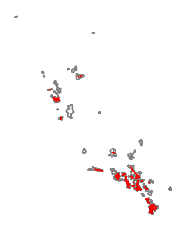

In [36]:
#plot queen lattice to check work
ax = ca_plot.plot(edgecolor='grey', facecolor='w')
ca,ax = w_queen.plot(ca,ax=ax, 
        edge_kws= dict(color='r', linestyle=':', linewidth=1),
        node_kws = dict(marker=''))
ax.set_axis_off()

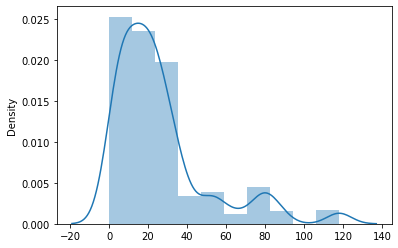

In [27]:
queen_card = pd.Series(w_queen.cardinalities)
sns.distplot(queen_card, bins=10)

In [65]:
year = ['1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991',
'1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

In [67]:
for i in year:
  str(i)

In [51]:
ca_time = gpd.GeoDataFrame(ca[['geometry', 'ZIP', 'Year','Action Obligation ($)']]).dropna()

In [70]:
ca_time.tail()

,geometry,ZIP,Year,Action Obligation ($)
874,"POLYGON ((-122.40384 37.78983, -122.40393 37.7...",94104,2020,2750.0
875,"POLYGON ((-120.67380 35.18110, -120.67432 35.1...",93401,2008,25785.0
876,"POLYGON ((-120.67380 35.18110, -120.67432 35.1...",93401,2018,4260.0
877,"POLYGON ((-120.67380 35.18110, -120.67432 35.1...",93401,2019,20000.0
878,"POLYGON ((-122.13476 37.39877, -122.13467 37.3...",94306,2019,71046.0


KeyError: ignored

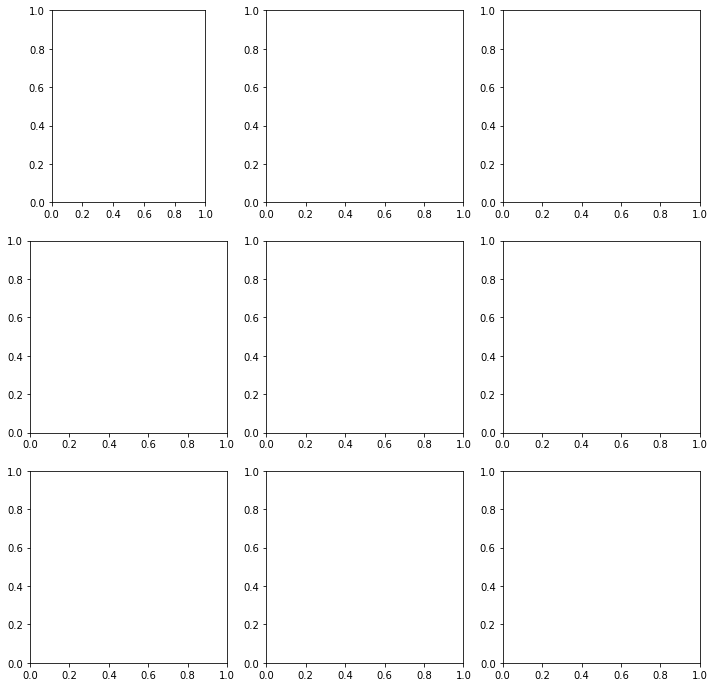

In [71]:
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate([year]):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    ca_time.plot(
        column=col, 
        ax=ax,
        scheme='Quantiles', 
        linewidth=0,
        cmap='RdPu'
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

**